# <ins> Análisis de datos de accidentes viales </ins>

## 1- Importando el dataset

### _Se importa el dataset con Pandas y se definen los nombres de las columnas, para poder referenciarlas posteriormente._

In [1]:
%matplotlib inline
import pandas as pd
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np


pd.set_option('display.max_columns', None)

#Importamos solamente los atributos que nos interesa analizar.
data_frame = pd.read_csv("Accidente.csv", header=0 ,usecols=["Severity","Junction", "Stop", "Traffic_Signal",
 "Sunrise_Sunset","Visibility(mi)", "Pressure(in)","Humidity(%)","Wind_Speed(mph)", "Distance(mi)", "Crossing", "Railway", "Start_Time"])

#data_frame = pd.read_csv("Accidente.csv", header=0 ,usecols=["Severity","Junction", "Stop", "Traffic_Signal", "Sunrise_Sunset"])

#Definimos la semilla que se utilizará a lo largo del proyecto.
random_state=42

## 2- Data Processing.

### _Se aplica One-Hot-Encoding para tratar los datos categóricos de forma adecuada para los modelos._

In [2]:
#Columna "Junction"
data_frame_dummies_junction = pd.get_dummies(data_frame['Junction'])
data_frame_dummies_junction = data_frame_dummies_junction.rename(columns=lambda s: "Junction_ {}".format(s))
data_frame = data_frame.drop(['Junction'], axis = 1)
data_frame = data_frame.join(data_frame_dummies_junction)

#Columna "Stop"
data_frame_dummies_stop = pd.get_dummies(data_frame['Stop'])
data_frame_dummies_stop = data_frame_dummies_stop.rename(columns=lambda s: "Stop_{}".format(s))
data_frame = data_frame.drop(['Stop'], axis = 1)
data_frame = data_frame.join(data_frame_dummies_stop)

#Columna "Traffic_Signal"
data_frame_dummies_traffic_signal = pd.get_dummies(data_frame['Traffic_Signal'])
data_frame_dummies_traffic_signal = data_frame_dummies_traffic_signal.rename(columns=lambda s: "Traffic_Signal_{}".format(s))
data_frame = data_frame.drop(['Traffic_Signal'], axis = 1)
data_frame = data_frame.join(data_frame_dummies_traffic_signal)

#Columna "Sunrise_Sunset"
data_frame_dummies_sunrise_sunset = pd.get_dummies(data_frame['Sunrise_Sunset'])
data_frame_dummies_sunrise_sunset = data_frame_dummies_sunrise_sunset.rename(columns=lambda s: "Sunrise_Sunset_" + s)
data_frame = data_frame.drop(['Sunrise_Sunset'], axis = 1)
data_frame = data_frame.join(data_frame_dummies_sunrise_sunset)


data_frame.head(5)

,Severity,Start_Time,Distance(mi),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Crossing,Railway,Junction_ False,Junction_ True,Stop_False,Stop_True,Traffic_Signal_False,Traffic_Signal_True,Sunrise_Sunset_Day,Sunrise_Sunset_Night
0,3,2016-02-08 05:46:00,0.01,91.0,29.68,10.0,NaN,False,False,1,0,1,0,1,0,0,1
1,2,2016-02-08 06:07:59,0.01,100.0,29.65,10.0,NaN,False,False,1,0,1,0,1,0,0,1
2,2,2016-02-08 06:49:27,0.01,100.0,29.67,10.0,3.5,False,False,1,0,1,0,0,1,0,1
3,3,2016-02-08 07:23:34,0.01,96.0,29.64,9.0,4.6,False,False,1,0,1,0,1,0,0,1
4,2,2016-02-08 07:39:07,0.01,89.0,29.65,6.0,3.5,False,False,1,0,1,0,0,1,1,0


In [3]:
data_frame["Start_Time"] = pd.to_datetime(data_frame["Start_Time"])

# Extract year, month, weekday and day
data_frame["Year"] = data_frame["Start_Time"].dt.year
data_frame["Month"] = data_frame["Start_Time"].dt.month
data_frame["Weekday"] = data_frame["Start_Time"].dt.weekday
data_frame["Day"] = data_frame["Start_Time"].dt.day

# Extract hour and minute
data_frame["Hour"] = data_frame["Start_Time"].dt.hour
data_frame["Minute"] = data_frame["Start_Time"].dt.minute

data_frame.drop("Start_Time",axis=1, inplace=True)


In [4]:
data_frame.dropna(axis=0, inplace=True)

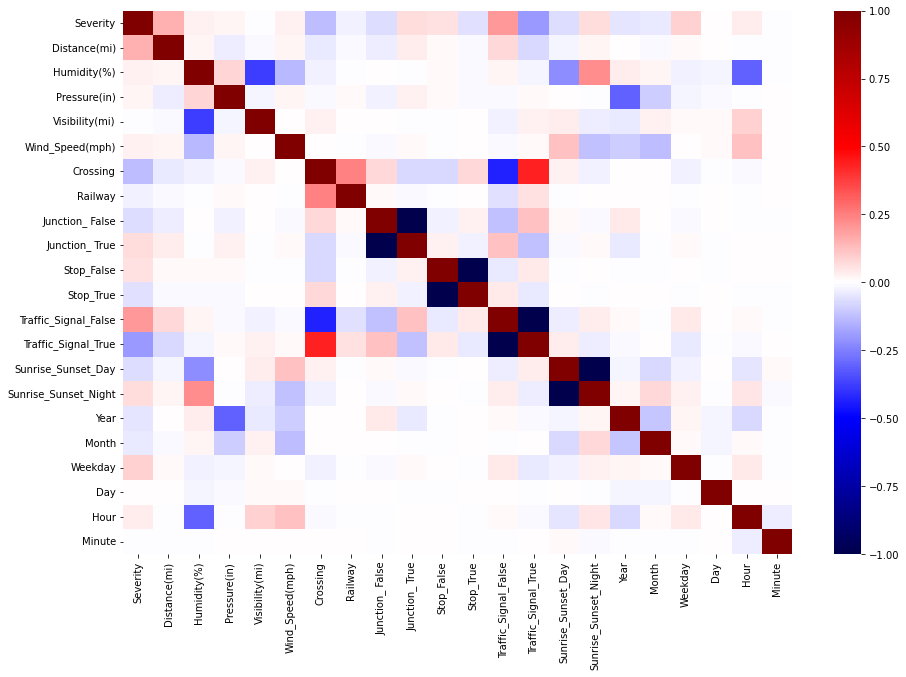

In [5]:
correlation_matrix = data_frame.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, cmap="seismic")
plt.gca().patch.set(hatch="X", edgecolor="#666")
plt.show()

## 3- Aplicación de Modelos - Linear SVC.

### _3.1- Se divide el dataset en x (datos sin el objetivo) e y (objetivo)._

Random under-sampling:
1    805
2    805
3    805
4    805
Name: Severity, dtype: int64


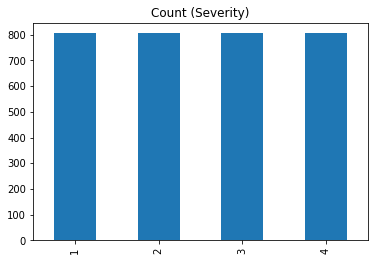

In [6]:
data_frame.drop("Crossing",axis=1, inplace=True)
data_frame.drop("Traffic_Signal_True",axis=1, inplace=True)
data_frame.drop("Visibility(mi)",axis=1, inplace=True)

count_class_1, count_class_2, count_class_3, count_class_4 = data_frame["Severity"].value_counts()

df_severity_1 = data_frame[data_frame['Severity'] == 1]
df_severity_2 = data_frame[data_frame['Severity'] == 2]
df_severity_3 = data_frame[data_frame['Severity'] == 3]
df_severity_4 = data_frame[data_frame['Severity'] == 4]

df_severity_1_under = df_severity_1.sample(805)
df_severity_2_under = df_severity_2.sample(805)
df_severity_3_under = df_severity_3.sample(805)
df_severity_4_under = df_severity_4.sample(805)

df_test_under = pd.concat([df_severity_1_under, df_severity_2_under, df_severity_3_under, df_severity_4_under], axis=0)

print('Random under-sampling:')
print(df_test_under['Severity'].value_counts())

df_test_under['Severity'].value_counts().plot(kind='bar', title='Count (Severity)')

x_sample = df_test_under.drop("Severity", axis=1)
y_sample = df_test_under["Severity"]

In [7]:
"""from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

rus = RandomUnderSampler(random_state=random_state)
X_rus, y_rus = rus.fit_resample(data_frame.drop("Severity", axis=1), data_frame["Severity"])"""

'from imblearn.under_sampling import RandomUnderSampler\nfrom imblearn.over_sampling import RandomOverSampler\n\nrus = RandomUnderSampler(random_state=random_state)\nX_rus, y_rus = rus.fit_resample(data_frame.drop("Severity", axis=1), data_frame["Severity"])'

### _3.2- Se aplica Grid Search para conseguir el parámetro de C que mejor ajusta al modelo._

In [8]:
parameters = {'C': [0.1, 0.2, 0.5, 1],'kernel': ['rbf', 'sigmoid', 'linear']}
modelSVC = svm.SVC(verbose=5, random_state=random_state)

grid = GridSearchCV(modelSVC, parameters, verbose=5, n_jobs=-1)

grid.fit(x_sample, y_sample)

print("Mejor valor de C:")
print(grid.best_params_)
print("Train score:", grid.score(x_sample, y_sample))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LibSVM]Mejor valor de C:
{'C': 0.1, 'kernel': 'linear'}
Train score: 0.4403726708074534


### _3.3- Una vez conseguido el mejor valor de C, se lo utiliza para entrenar al modelo con el mismo._

In [11]:
xtrain, xtest, ytrain, ytest = train_test_split(x_sample, y_sample, stratify=y_sample, random_state=random_state)

linear_svc = svm.SVC(**grid.best_params_,random_state=random_state)

linear_svc.fit(xtrain, ytrain)

print("Train score:", linear_svc.score(xtrain, ytrain))
print("Test score:", linear_svc.score(xtest, ytest))
print("YTRAIN MAX: {}".format(np.max(ytrain)))
print("YTRAIN MIN: {}".format(np.min(ytrain)))
print("YTEST MAX: {}".format(np.max(ytest)))
print("YTEST MIN: {}".format(np.min(ytest)))


Train score: 0.45175983436853
Test score: 0.4161490683229814
YTRAIN MAX: 4
YTRAIN MIN: 1
YTEST MAX: 4
YTEST MIN: 1


### _3.4- Se predicen los resultados de Severity de acuerdo a los datos de testing, y se proyecta su resultado en una matriz de confusión._

YPRED MAX: 4
YPRED MIN: 1
YTRAIN MAX: 4
YTRAIN MIN: 1
YTEST MAX: 4
YTEST MIN: 1


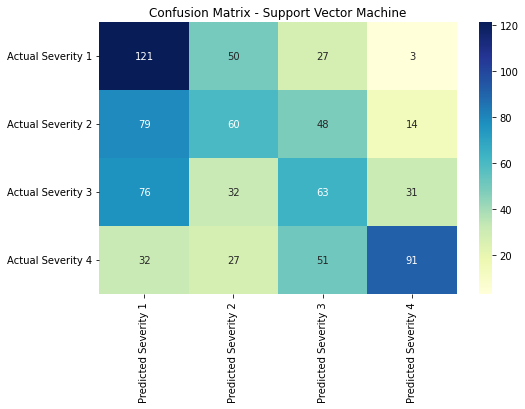

3    202
2    201
1    201
4    201
Name: Severity, dtype: int64


In [12]:
y_pred = linear_svc.predict(xtest)
confmat = confusion_matrix(y_true=ytest, y_pred=y_pred)

print("YPRED MAX: {}".format(np.max(y_pred)))
print("YPRED MIN: {}".format(np.min(y_pred)))
print("YTRAIN MAX: {}".format(np.max(ytrain)))
print("YTRAIN MIN: {}".format(np.min(ytrain)))
print("YTEST MAX: {}".format(np.max(ytest)))
print("YTEST MIN: {}".format(np.min(ytest)))

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Support Vector Machine")
plt.show()
print(ytest.value_counts())